# Predicting Antibody Binding from Amino Acid Sequences

## Data Acquisition

This notebook focuses on acquiring the AVIDa-SARS-CoV-2 dataset from Hugging Face.

## 1. Import Libraries

In [11]:
# Data processing
import pandas as pd
import numpy as np

# Hugging Face datasets
from datasets import load_dataset

# File handling
import os
import sys
import warnings

# Progress bar
from tqdm.notebook import tqdm

# Ignore warnings
warnings.filterwarnings('ignore')

## 2. Define Paths

In [12]:
# Define paths
DATA_RAW_DIR = '../data/raw'
DATA_PROCESSED_DIR = '../data/processed'

# Create directories if they don't exist
os.makedirs(DATA_RAW_DIR, exist_ok=True)
os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)

## 3. Download Data from Hugging Face

We'll download the AVIDa-SARS-CoV-2 dataset from Hugging Face. This dataset contains 77,003 full-length VHH (alpaca) antibody sequences, including 22,002 binders and 55,001 non-binders across 12 SARS-CoV-2 variants.

In [13]:
# Load the dataset from Hugging Face
print("Loading AVIDa-SARS-CoV-2 dataset from Hugging Face...")
dataset = load_dataset("COGNANO/AVIDa-SARS-CoV-2")
print("Dataset loaded successfully!")

# Display dataset information
print("\nDataset structure:")
print(dataset)

Loading AVIDa-SARS-CoV-2 dataset from Hugging Face...
Dataset loaded successfully!

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['VHH_sequence', 'Ag_label', 'label', 'subject_species', 'subject_name', 'subject_sex'],
        num_rows: 49685
    })
    test: Dataset({
        features: ['VHH_sequence', 'Ag_label', 'label', 'subject_species', 'subject_name', 'subject_sex'],
        num_rows: 27318
    })
})


## 4. Explore Dataset Structure

Let's explore the structure of the dataset to understand its contents.

In [14]:
# Check available splits
print("Available splits:")
for split in dataset.keys():
    print(f"- {split}: {len(dataset[split])} samples")

# Check features
print("\nFeatures:")
for feature in dataset[list(dataset.keys())[0]].features:
    print(f"- {feature}")

# Display a few examples
print("\nSample data:")
first_split = list(dataset.keys())[0]
for i in range(5):
    if i < len(dataset[first_split]):
        example = dataset[first_split][i]
        print(f"\nExample {i+1}:")
        for key in dataset[first_split].features:
            value = example[key]
            # Truncate long sequences for display
            if key == 'VHH_sequence' and isinstance(value, str) and len(value) > 50:
                print(f"  {key}: {value[:50]}... (length: {len(value)})")
            else:
                print(f"  {key}: {value}")

Available splits:
- train: 49685 samples
- test: 27318 samples

Features:
- VHH_sequence
- Ag_label
- label
- subject_species
- subject_name
- subject_sex

Sample data:

Example 1:
  VHH_sequence: MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGAVQPGGSLRLSCAASGFT... (length: 146)
  Ag_label: Alpha+E484K_cell
  label: 1
  subject_species: alpaca
  subject_name: puta
  subject_sex: male

Example 2:
  VHH_sequence: MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAASGFT... (length: 143)
  Ag_label: Alpha+E484K_cell
  label: 0
  subject_species: alpaca
  subject_name: puta
  subject_sex: male

Example 3:
  VHH_sequence: MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAASAHT... (length: 153)
  Ag_label: Alpha+E484K_cell
  label: 1
  subject_species: alpaca
  subject_name: puta
  subject_sex: male

Example 4:
  VHH_sequence: MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQAGGSLRVSCAATGLT... (length: 149)
  Ag_label: Alpha+E484K_cell
  label: 0
  subject_species: alpaca
  subject_name: puta
  subject_sex: male

Example 5:
  VHH_s

## 5. Convert to Pandas DataFrame

We'll convert the Hugging Face dataset to Pandas DataFrames for easier manipulation.

In [15]:
# Convert to pandas DataFrames
dfs = {}
for split in dataset.keys():
    dfs[split] = dataset[split].to_pandas()
    print(f"{split} split converted to DataFrame with shape: {dfs[split].shape}")

# Display the first few rows of the training set
if 'train' in dfs:
    print("\nFirst few rows of the training set:")
    display(dfs['train'].head())
elif len(dfs) > 0:
    first_split = list(dfs.keys())[0]
    print(f"\nFirst few rows of the {first_split} split:")
    display(dfs[first_split].head())

train split converted to DataFrame with shape: (49685, 6)
test split converted to DataFrame with shape: (27318, 6)

First few rows of the training set:


,VHH_sequence,Ag_label,label,subject_species,subject_name,subject_sex
0,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGAVQPGGSLRLSCAA...,Alpha+E484K_cell,1,alpaca,puta,male
1,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAA...,Alpha+E484K_cell,0,alpaca,puta,male
2,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCAA...,Alpha+E484K_cell,1,alpaca,puta,male
3,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQAGGSLRVSCAA...,Alpha+E484K_cell,0,alpaca,puta,male
4,MKYLLPTAAAGLLLLAAQPAMAQVQLQESGGGLVQPGGSLRLSCVA...,Alpha+E484K_cell,1,alpaca,puta,male


## 6. Save Raw Data

We'll save the raw data to disk for use in subsequent notebooks.

In [16]:
# Save the raw data to CSV files
for split, df in dfs.items():
    output_path = os.path.join(DATA_RAW_DIR, f"{split}.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved {split} split to {output_path}")

Saved train split to ../data/raw/train.csv
Saved test split to ../data/raw/test.csv


## 7. Basic Data Analysis

Let's perform some basic analysis on the dataset to understand its characteristics.

In [17]:
# Analyze class distribution
for split, df in dfs.items():
    if 'label' in df.columns:
        print(f"\nClass distribution in {split} split:")
        class_counts = df['label'].value_counts()
        print(class_counts)
        print(f"Class balance: {class_counts.values[0] / class_counts.values[-1]:.2f}:1")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"\nMissing values in {split} split:")
        print(missing_values[missing_values > 0])
    else:
        print(f"\nNo missing values in {split} split")


Class distribution in train split:
label
0    34285
1    15400
Name: count, dtype: int64
Class balance: 2.23:1

No missing values in train split

Class distribution in test split:
label
0    20716
1     6602
Name: count, dtype: int64
Class balance: 3.14:1

No missing values in test split


## 8. Sequence Length Analysis

Let's analyze the distribution of sequence lengths in the dataset.


Sequence length statistics for train split:
Min length: 94
Max length: 163
Mean length: 145.37
Median length: 146.0


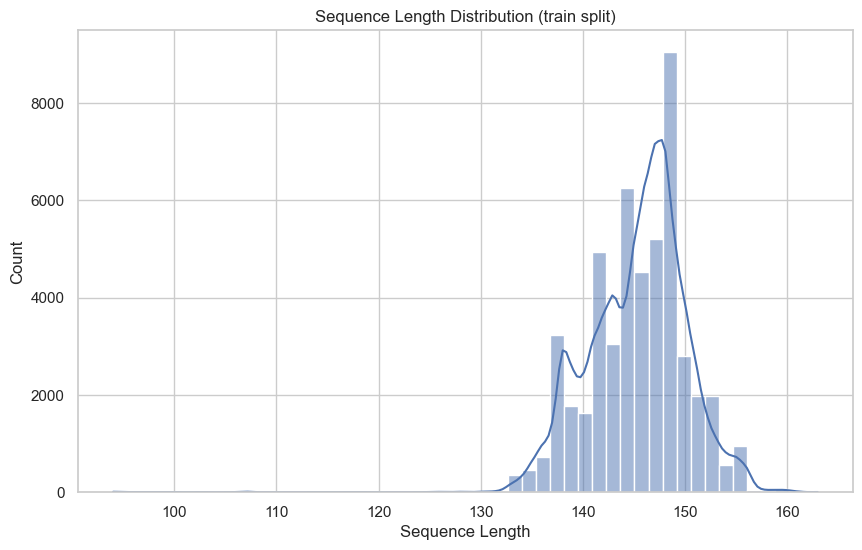

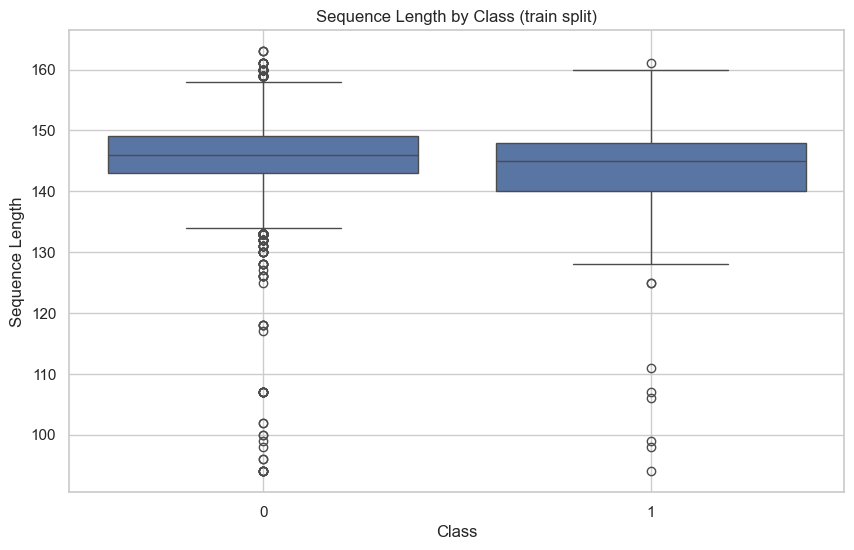


Sequence length statistics for test split:
Min length: 94
Max length: 166
Mean length: 146.62
Median length: 147.0


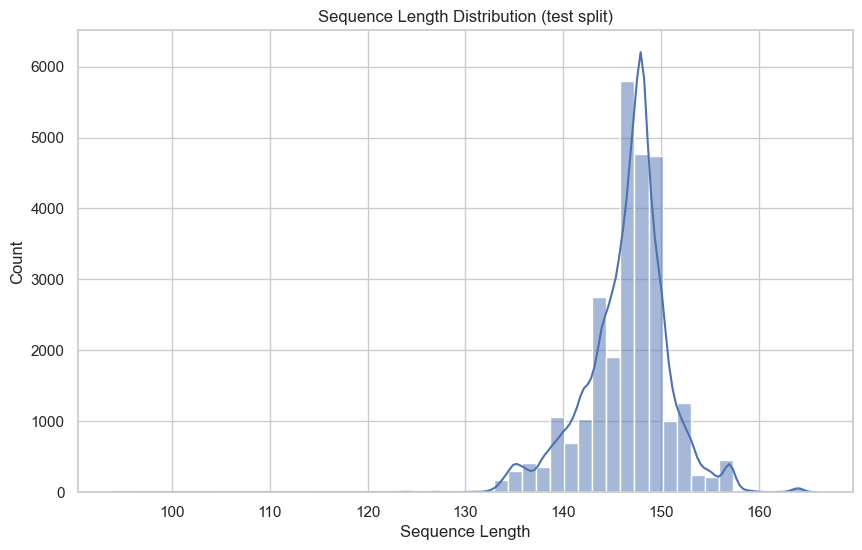

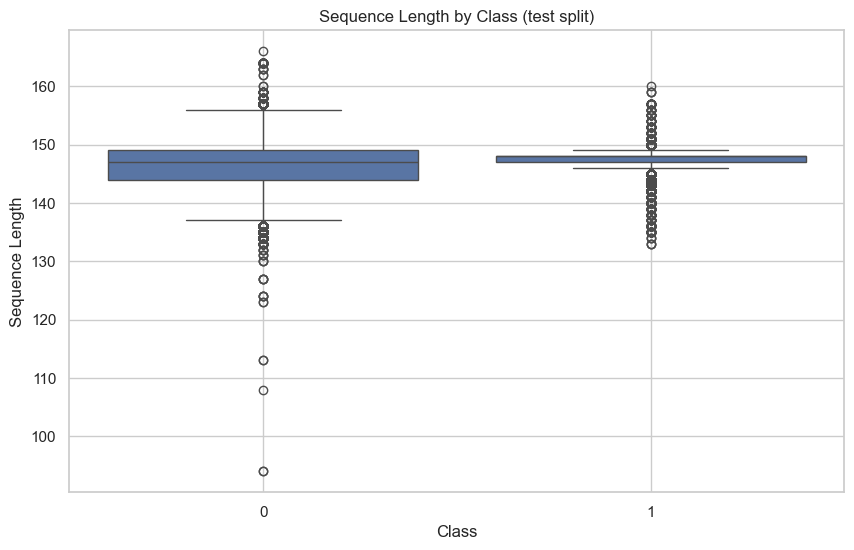

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
sns.set_theme(style="whitegrid")

# Calculate sequence lengths
for split, df in dfs.items():
    if 'VHH_sequence' in df.columns:
        df['sequence_length'] = df['VHH_sequence'].apply(len)
        
        print(f"\nSequence length statistics for {split} split:")
        print(f"Min length: {df['sequence_length'].min()}")
        print(f"Max length: {df['sequence_length'].max()}")
        print(f"Mean length: {df['sequence_length'].mean():.2f}")
        print(f"Median length: {df['sequence_length'].median()}")
        
        # Plot sequence length distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x='sequence_length', bins=50, kde=True)
        plt.title(f"Sequence Length Distribution ({split} split)")
        plt.xlabel("Sequence Length")
        plt.ylabel("Count")
        plt.grid(True)
        plt.show()
        
        # If we have labels, plot sequence length by class
        if 'label' in df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df, x='label', y='sequence_length')
            plt.title(f"Sequence Length by Class ({split} split)")
            plt.xlabel("Class")
            plt.ylabel("Sequence Length")
            plt.grid(True)
            plt.show()

## 9. Next Steps

The data has been successfully downloaded from Hugging Face and saved to disk. In the next notebook, we'll focus on data preprocessing and cleaning.